# start

compare Reply0520A1; add langdayofweek

In [1]:
TGT='Reply'
PRFX='Reply0520B1'

trntmstmp=1584412344
tsttmstmp=1590075806

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')

SEED=101

trnsz = int(1e6)
valsz = trnsz//10
print(f'train_total {trnsz:,}, valsz {valsz:,}')



import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
train_total 1,000,000, valsz 100,000
['2020-03-17 02:32:24', '2020-05-21 15:43:26']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
import gc

# import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
# import optuna.integration.lightgbm as lgb
# optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(100000, 24)


retwt          0.11211
reply          0.02754
like           0.43929
retwt_cmmnt    0.00801
dtype: float64

CPU times: user 1.29 s, sys: 156 ms, total: 1.45 s
Wall time: 1.45 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(3700000, 24)


retwt          0.113006
reply          0.027500
like           0.439600
retwt_cmmnt    0.007701
dtype: float64

CPU times: user 35.6 s, sys: 4.08 s, total: 39.7 s
Wall time: 40.8 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(1000000, 24) 0.101749
3700000 101749 1000000 101749


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
5,101\t1434\t107854\t18260\t31904\t111431\t74759...,NaN,0EB15633A8CC0A6E3917C272F43E6DF3,NaN,NaN,NaN,TopLevel,022EC308651FACB02794A8147AEE1B78,1581218899,A7E00C86B4E3709D589754A51042A360,1198215,662,True,1246548812,016212C070A76EAB37E8ED93CA509BA9,0,42,False,1578271262,False,False,True,False,False
51,101\t10473\t10116\t10132\t12603\t97953\t25307\...,NaN,7C71C144E7B9F2D87F1F4DDB40AB1C49,NaN,NaN,NaN,TopLevel,2996EB2FE8162C076D070A4C8D6532CD,1581203618,B0CBECD53C3B945C875C55DDFF56D13F,1424,854,False,1394906655,01625341E5A48963E5AA7DFFDC4436D4,643,327,False,1372760933,True,False,True,False,False
63,101\t56898\t137\t24362\t131\t100\t196\t36351\t...,NaN,ADCF033A7C7087C1506E2BC3E2D8F092,NaN,NaN,NaN,Retweet,717293301FE296B0B61950D041485825,1581258397,ECD90FC37F0A7C15C82834FDDEEDC21A,1753,811,False,1568347799,01625CCEC5A4C322FC247DB9E223CC08,147,1355,False,1355850070,False,False,True,False,False
75,101\t12441\t105702\t793\t61783\t34022\t60578\t...,NaN,7EB0824DDA3D28844CC0FF65B7C4AA08,NaN,NaN,NaN,TopLevel,167115458A0DBDFF7E9C0C53A83BAC9B,1581271814,D905F31F909CC63C2BBEB7F6B43487FE,175998,116,False,1466830888,01626B64A2570C2807AB97716262FBA9,90,139,False,1364278366,False,False,True,False,False
83,101\t69532\t10107\t12372\t10160\t19048\t136\t1...,NaN,0A95516F028EBFF6B551DB32C4B2D1B5,Video,NaN,NaN,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581214010,88E80BAB56E6F59E4EF012A8B12D3BAE,8825,8024,False,1557262802,0162759D8908AA8C849F06086A023D85,26265,24215,False,1557422269,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    df['langdayofweek']=df.lang+'_'+df.dayofweek.astype(str)
    

#     #freq of feature values
#     print(dtnow(), 'freq of columns using CountEncoder')
#     encoder = ce.CountEncoder()
#     encoded = encoder.fit_transform(
#     df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
#        'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
#        'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
#        'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
#     encoded = encoded.astype(int)/lendf
#     encoded.columns = [f'frq_{col}' for col in encoded.columns]
#     df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
#     print(dtnow(), 'freq of tags')
#     for tgnm in tgnms:
#         vs = [j for i in df[f'lst_{tgnm}'] for j in i]
#         cnt = Counter(vs)
#         frq = {k:v/lendf for k,v in cnt.items()}
#         df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
#         df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-05-21 01:54:53 start
2020-05-21 01:55:39 done
CPU times: user 39 s, sys: 3.24 s, total: 42.2 s
Wall time: 45.9 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-05-21 01:55:39 start
2020-05-21 01:55:42 done
CPU times: user 2.74 s, sys: 93.5 ms, total: 2.84 s
Wall time: 3.04 s


## tr vl split

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
cols_category=['twttyp', 'lang', 'langhour', 'langdayofweek']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [13]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [14]:
cols_feat

['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'langdayofweek']

In [15]:
print(len(cols_feat))


33


In [16]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat

In [17]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
# params.update({'lambda_l1': 2.7218581416769004e-07,
#  'lambda_l2': 3.907768244028144e-06,
#  'num_leaves': 152,
#  'feature_fraction': 0.4,
#  'bagging_fraction': 1.0,
#  'bagging_freq': 0,
#  'min_child_samples': 100})
# print(params)


results['params'] = params

In [18]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271791	vl's binary_logloss: 0.28135
Early stopping, best iteration is:
[99]	tr's binary_logloss: 0.271897	vl's binary_logloss: 0.281343
CPU times: user 2min 50s, sys: 10min 42s, total: 13min 32s
Wall time: 50.6 s


## tr vl trajec

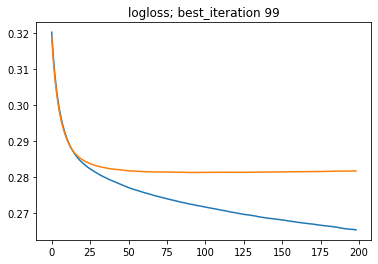

In [19]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

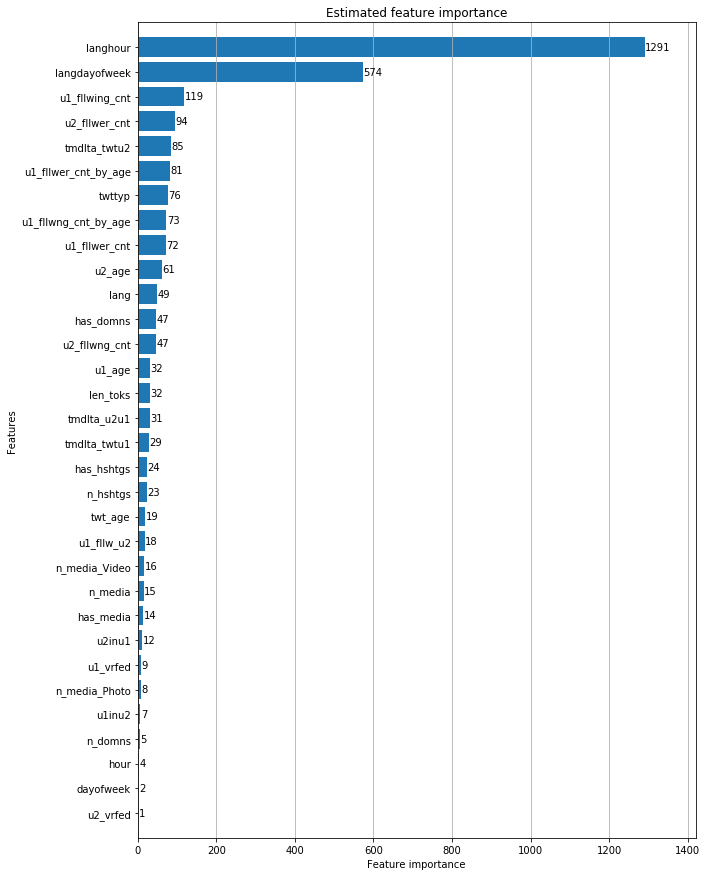

In [20]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [21]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
31,langhour,1291
32,langdayofweek,574
3,u1_fllwing_cnt,119
5,u2_fllwer_cnt,94
25,tmdlta_twtu2,85
29,u1_fllwer_cnt_by_age,81
0,twttyp,76
30,u1_fllwng_cnt_by_age,73
2,u1_fllwer_cnt,72
28,u2_age,61


In [22]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 1291),
 ('langdayofweek', 574),
 ('u1_fllwing_cnt', 119),
 ('u2_fllwer_cnt', 94),
 ('tmdlta_twtu2', 85),
 ('u1_fllwer_cnt_by_age', 81),
 ('twttyp', 76),
 ('u1_fllwng_cnt_by_age', 73),
 ('u1_fllwer_cnt', 72),
 ('u2_age', 61),
 ('lang', 49),
 ('u2_fllwng_cnt', 47),
 ('has_domns', 47),
 ('len_toks', 32),
 ('u1_age', 32),
 ('tmdlta_u2u1', 31),
 ('tmdlta_twtu1', 29),
 ('has_hshtgs', 24),
 ('n_hshtgs', 23),
 ('twt_age', 19),
 ('u1_fllw_u2', 18),
 ('n_media_Video', 16),
 ('n_media', 15),
 ('has_media', 14),
 ('u2inu1', 12),
 ('u1_vrfed', 9),
 ('n_media_Photo', 8),
 ('u1inu2', 7),
 ('n_domns', 5),
 ('hour', 4),
 ('dayofweek', 2),
 ('u2_vrfed', 1),
 ('n_media_GIF', 0)]

In [23]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'langdayofweek',
 'u1_fllwing_cnt',
 'u2_fllwer_cnt',
 'tmdlta_twtu2',
 'u1_fllwer_cnt_by_age',
 'twttyp',
 'u1_fllwng_cnt_by_age',
 'u1_fllwer_cnt',
 'u2_age',
 'lang',
 'u2_fllwng_cnt',
 'has_domns',
 'len_toks',
 'u1_age',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'has_hshtgs',
 'n_hshtgs',
 'twt_age',
 'u1_fllw_u2',
 'n_media_Video',
 'n_media',
 'has_media',
 'u2inu1',
 'u1_vrfed',
 'n_media_Photo',
 'u1inu2',
 'n_domns',
 'hour',
 'dayofweek',
 'u2_vrfed']

# eval

In [24]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 25.7 s, sys: 13.4 s, total: 39.1 s
Wall time: 4.52 s


In [25]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 3.99 s, sys: 2.21 s, total: 6.2 s
Wall time: 3.69 s


In [26]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3446
auc_vl:  0.2890
auc_val: 0.1057

rce_tr:  17.3845
rce_vl:  14.1624
rce_val: 11.3749


## score

In [27]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.1057-11.3749


# save results

In [28]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [ ]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
cols_feat = results['cols_feat']

In [ ]:
## prep

In [ ]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
#     nrows=10
)

In [ ]:
dftst.shape

In [ ]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

In [ ]:
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

In [ ]:
## predict

In [ ]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

In [29]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)

NameError: name 'dftst' is not defined